# Executive Exploratory Data Analysis

Key Takeaways: 

- DCA is a reasonable baseline Bitcoin accumulation strategy in the absence of other strong signals. However, its performance depends on overall market regime conditions such as bull/bear/sideways and high/low volatility. Other baseline strategies such as using moving averages appear to be more effective in some market conditions. As a result, regime analysis will play a signficant role in developing the accumulation strategy. 

- Polymarket data will likely play a role in the accumulation strategy, with the activity and sentiment of Bitcoin markets providing useful information. After activity shocks in Polymarket BTC markets (spikes in trading volume regardless of the sentiment), Bitcoin tends to outperform the baseline over the following 30 and 60 days. After sentiment shocks (spikes in bullish activity), Bitcoin tends to underperform the baseline, but with less statistical signficance. This suggests that attention on these Bitcoin markets could be a leading indicator, while the sentiment of these bets could act as a contrarian signal. 

Next Steps:
- Further explore how to stratify the different regimes to determine when market conditions have changed. This will likely include the use of change detection models and clustering algorithms. 
- Build final BTC accumulation model and evaluate performance when applied to backtest. 

## Imports and Configuration

In [115]:
from pathlib import Path
from datetime import datetime
from scipy.stats import ttest_ind
from scipy.stats import binomtest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import seaborn as sns

sns.set_theme(style="whitegrid")

CANDIDATE_ROOTS = [Path.cwd(), Path.cwd().parent]
PROJECT_ROOT = next(
    (p for p in CANDIDATE_ROOTS if (p / "data").exists() and (p / "template").exists()),
    None,
)
if PROJECT_ROOT is None:
    raise FileNotFoundError("Could not find project root with /data and /template directories. Ensure that you are running this notebook from within the project directory.")

DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = PROJECT_ROOT / "eda" / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

COIN_METRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

## Load CoinMetrics and Polymarket Data

In [116]:
def load_bitcoin_data(filepath: Path) -> pl.DataFrame:
    df = (
        pl.scan_csv(filepath, infer_schema_length=10000)
        .with_columns(pl.col("time").str.to_datetime())
        .collect()
        .sort("time")
    )

    if "PriceUSD" in df.columns and "PriceUSD_coinmetrics" not in df.columns:
        df = df.with_columns(pl.col("PriceUSD").alias("PriceUSD_coinmetrics"))

    return df

btc_df = load_bitcoin_data(COIN_METRICS_PATH)
print(f"Loaded BTC rows: {btc_df.height:,} | columns: {btc_df.width}")

Loaded BTC rows: 6,221 | columns: 33


In [117]:
def _fix_timestamp_columns(df: pl.DataFrame) -> pl.DataFrame:
    """Fix parquet timestamps and null out pre-2020 values"""
    threshold_dt = datetime(2020, 1, 1)

    for col in df.columns:
        if not any(k in col.lower() for k in ["timestamp", "trade", "created_at", "end_date"]):
            continue
    
        dtype = df.schema[col]
        if not dtype.is_temporal():
            continue

        if dtype == pl.Datetime:
            max_val = df.select(pl.col(col).max()).item()
            if max_val is not None and max_val < threshold_dt:
                df = df.with_columns((pl.col(col).cast(pl.Int64) * 1000).cast(pl.Datetime).alias(col))

        threshold_value = threshold_dt.date() if dtype == pl.Date else threshold_dt
        df = df.with_columns(
            pl.when(pl.col(col) < threshold_value)
            .then(None)
            .otherwise(pl.col(col))
            .alias(col)
        )
    
    return df

def load_polymarket_data(datadir: Path) -> dict[str, pl.DataFrame]:
    data: dict[str, pl.DataFrame] = {}
    for path in datadir.glob("*.parquet"):
        key = path.stem.replace("finance_politics_", "")

        df = pl.scan_parquet(path).collect()
        df = _fix_timestamp_columns(df)
        data[key] = df
    
    return data

poly_data = load_polymarket_data(POLYMARKET_DIR)
print(f"Loaded Polymarket parquet files:")
list(poly_data.keys())

Loaded Polymarket parquet files:


['odds_history', 'summary', 'trades', 'markets', 'tokens', 'event_stats']

## Data Completeness

In [118]:
print(f"BTC date range: {btc_df.select(pl.col('time').min()).item()} -> {btc_df.select(pl.col('time').max()).item()}")
print(f"BTC shape: {btc_df.shape}")

key_btc_cols = [c for c in ["PriceUSD_coinmetrics", "CapMrktCurUSD", "HashRate", "TxCnt", "CapMVRVCur"] if c in btc_df.columns]

btc_missing = pl.DataFrame(
    {
        "column": key_btc_cols,
        "null_pct": [100 * btc_df[c].null_count() / btc_df.height for c in key_btc_cols],
    }
).sort("null_pct", descending=True)

btc_summary = btc_df.select(key_btc_cols).describe()

btc_missing, btc_summary

BTC date range: 2009-01-03 00:00:00 -> 2026-01-14 00:00:00
BTC shape: (6221, 33)


(shape: (5, 2)
 ┌──────────────────────┬──────────┐
 │ column               ┆ null_pct │
 │ ---                  ┆ ---      │
 │ str                  ┆ f64      │
 ╞══════════════════════╪══════════╡
 │ PriceUSD_coinmetrics ┆ 9.033917 │
 │ CapMrktCurUSD        ┆ 9.033917 │
 │ CapMVRVCur           ┆ 9.033917 │
 │ HashRate             ┆ 0.112522 │
 │ TxCnt                ┆ 0.016075 │
 └──────────────────────┴──────────┘,
 shape: (9, 6)
 ┌────────────┬──────────────────────┬───────────────┬───────────┬───────────────┬────────────┐
 │ statistic  ┆ PriceUSD_coinmetrics ┆ CapMrktCurUSD ┆ HashRate  ┆ TxCnt         ┆ CapMVRVCur │
 │ ---        ┆ ---                  ┆ ---           ┆ ---       ┆ ---           ┆ ---        │
 │ str        ┆ f64                  ┆ f64           ┆ f64       ┆ f64           ┆ f64        │
 ╞════════════╪══════════════════════╪═══════════════╪═══════════╪═══════════════╪════════════╡
 │ count      ┆ 5659.0               ┆ 5659.0        ┆ 6214.0    ┆ 6220.0        ┆

There are a fair amount of missing data points when examining the CoinMetrics dataset. Several of the columns contain exactly 562 null datapoints, suggesting the missing data for these variables are from the same days. To confirm, we look at which dates contain these null values. 

In [119]:
print("Missing Data Start and End Dates: ")
with pl.Config(tbl_rows=20):
    display(
        btc_df.filter(pl.col("time") < btc_df["time"].max())
        .unpivot(index="time")
        .filter(pl.col("value").is_null())
        .group_by("variable")
        .agg(
            pl.col("time").min().alias("missing_start"),
            pl.col("time").max().alias("missing_end"),
            pl.col("time").count().alias("missing_count")
        )
        .sort("missing_count", descending=True)
    )

Missing Data Start and End Dates: 


variable,missing_start,missing_end,missing_count
str,datetime[μs],datetime[μs],u32
"""ReferenceRateUSD""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""ReferenceRateEUR""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""ReferenceRate""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""ReferenceRateETH""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""CapMrktEstUSD""",2009-01-03 00:00:00,2019-06-21 00:00:00,3822
"""ROI1yr""",2009-01-03 00:00:00,2011-07-17 00:00:00,926
"""ROI30d""",2009-01-03 00:00:00,2010-08-16 00:00:00,591
"""volume_reported_spot_usd_1d""",2009-01-03 00:00:00,2010-07-17 00:00:00,561
"""FlowInExUSD""",2009-01-03 00:00:00,2010-07-17 00:00:00,561


The variables "ReferenceRateEUR", "ReferenceRate", "ReferenceRateETH", and "ReferenceRateUSD" have a substantial amount of missing data points, which greatly affects the usability of these variables. As a result, these 4 variables will not be used in our modeling. Examining the last dates for missing values in the remaining columns, we see that the missing data is present only in the very early days of bitcoin between 2009 and 2011, which is acceptable for this analysis. Our focus will be on data starting from 2017 onwards to address some of these missing values and overall noisy data that is present in these earlier price discovery stages. 

## Baseline Strategy Analysis - How effective is Dollar Cost Averaging (DCA)?

In [120]:
EVAL_START = pd.Timestamp("2018-01-01")
EVAL_END_TARGET = pd.Timestamp("2025-12-31")
WINDOW_OFFSET = pd.DateOffset(years=1)
N_RANDOM = 200
RANDOM_MULTI_DAYS = 12
SEED = 42

btc_daily_pd = (
    btc_df
    .select(["time", "PriceUSD_coinmetrics"])
    .drop_nulls()
    .to_pandas()
    .rename(columns={"time": "date", "PriceUSD_coinmetrics": "price"})
)
btc_daily_pd["date"] = pd.to_datetime(btc_daily_pd["date"].dt.normalize())
btc_daily_pd = (
    btc_daily_pd
    .sort_values("date")
    .drop_duplicates(subset=["date"], keep="last")
    .set_index("date")
)

EVAL_END = min(EVAL_END_TARGET, btc_daily_pd.index.max())
window_starts = pd.date_range(EVAL_START, EVAL_END - WINDOW_OFFSET, freq="D")

expected_dates = pd.date_range(EVAL_START, EVAL_END, freq="D")
missing_eval_dates = expected_dates.difference(btc_daily_pd.index)

print(f"Evaluation date range: {EVAL_START.date()} to {EVAL_END.date()}")
print(f"Rolling 1-year windows: {len(window_starts):,}")
print(f"Missing price dates in eval range: {len(missing_eval_dates):,}")

Evaluation date range: 2018-01-01 to 2025-12-31
Rolling 1-year windows: 2,557
Missing price dates in eval range: 0


In [121]:
def evaluate_window(price_values: np.ndarray, rng: np.random.Generator) -> dict:
    inv_price = 1e8 / price_values
    n_days = len(inv_price)

    dca_spd = inv_price.mean()
    lump_start_spd = inv_price[0]
    lump_end_spd = inv_price[-1]

    oracle_best_spd = inv_price.max()
    oracle_worst_spd = inv_price.min()
    oracle_denom = oracle_best_spd - oracle_worst_spd
    dca_oracle_percentile = np.nan if oracle_denom == 0 else 100 * (dca_spd - oracle_worst_spd) / oracle_denom

    # Random one-shot baseline, spend all budget on one random day
    random_lump_idx = rng.integers(0, n_days, size=N_RANDOM)
    random_lump_spd = inv_price[random_lump_idx]

    # Random multi-shot baseline, spend budget equally on 12 random days
    random_multi_idx = rng.integers(0, n_days, size=(N_RANDOM, RANDOM_MULTI_DAYS))
    random_multi_spd = inv_price[random_multi_idx].mean(axis=1)

    trend_1y = (price_values[-1] / price_values[0]) - 1
    daily_ret = pd.Series(price_values).pct_change().dropna().to_numpy()
    ann_vol_1y = np.nan if daily_ret.size < 2 else daily_ret.std(ddof=1) * np.sqrt(365)

    return {
        "n_days": n_days,
        "dca_spd": dca_spd,
        "lump_start_spd": lump_start_spd,
        "lump_end_spd": lump_end_spd,
        "oracle_best_spd": oracle_best_spd,
        "oracle_worst_spd": oracle_worst_spd,
        "dca_oracle_percentile": dca_oracle_percentile,
        "random_lump_mean_spd": random_lump_spd.mean(),
        "random_lump_median_spd": np.median(random_lump_spd),
        "random_lump_p05_spd": np.quantile(random_lump_spd, 0.05),
        "random_lump_p95_spd": np.quantile(random_lump_spd, 0.95),
        "random_multi_mean_spd": random_multi_spd.mean(),
        "random_multi_median_spd": np.median(random_multi_spd),
        "dca_vs_random_lump_percentile": 100 * (random_lump_spd < dca_spd).mean(),
        "dca_vs_random_multi_percentile": 100 * (random_multi_spd < dca_spd).mean(),
        "win_vs_lump_start": dca_spd > lump_start_spd,
        "win_vs_lump_end": dca_spd > lump_end_spd,
        "win_vs_random_lump_median": dca_spd > np.median(random_lump_spd),
        "win_vs_random_multi_median": dca_spd > np.median(random_multi_spd),
        "beats_random_lump_p05": dca_spd > np.quantile(random_lump_spd, 0.05),
        "trend_1y": trend_1y,
        "ann_vol_1y": ann_vol_1y,
    }

rng = np.random.default_rng(SEED)
rows = []

for start in window_starts:
    end = start + WINDOW_OFFSET
    window_prices = btc_daily_pd.loc[start:end, "price"].dropna()

    row = evaluate_window(window_prices.to_numpy(), rng)
    row["window_start"] = start
    row["window_end"] = end
    rows.append(row)

dca_eval_df = pd.DataFrame(rows).set_index("window_start").sort_index()
print(f"Evaluated windows: {len(dca_eval_df):,}")
dca_eval_df.head(3)

Evaluated windows: 2,557


,n_days,dca_spd,lump_start_spd,lump_end_spd,oracle_best_spd,oracle_worst_spd,dca_oracle_percentile,random_lump_mean_spd,random_lump_median_spd,random_lump_p05_spd,...,dca_vs_random_lump_percentile,dca_vs_random_multi_percentile,win_vs_lump_start,win_vs_lump_end,win_vs_random_lump_median,win_vs_random_multi_median,beats_random_lump_p05,trend_1y,ann_vol_1y,window_end
window_start,,,,,,,,,,,,,,,,,,,,,
2018-01-01,366,14767.937008,7426.852772,26259.691643,31396.44436,5846.725992,34.917062,14494.562958,14703.647476,8984.266342,...,50.0,49.5,True,False,True,False,True,-0.717177,0.829768,2019-01-01
2018-01-02,366,14817.734901,6777.674949,25652.881956,31396.44436,5846.725992,35.111968,15499.547628,14696.103222,8829.243549,...,51.0,48.5,True,False,True,False,True,-0.735793,0.824318,2019-01-02
2018-01-03,366,14871.414334,6662.098173,26424.347405,31396.44436,5846.725992,35.322066,14983.241494,14522.905652,8904.234301,...,55.0,57.0,True,False,True,True,True,-0.747880,0.824497,2019-01-03


In [122]:
def bootstrap_ci_mean(values, n_boot: int = 2000, alpha: float = 0.05, seed: int = 123):
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return (np.nan, np.nan, np.nan)

    local_rng = np.random.default_rng(seed)
    samples = local_rng.choice(arr, size=(n_boot, arr.size), replace=True)
    means = samples.mean(axis=1)
    lower = np.quantile(means, alpha / 2)
    upper = np.quantile(means, 1 - alpha / 2)
    return (arr.mean(), lower, upper)


win_rate_random_lump = dca_eval_df["win_vs_random_lump_median"].mean()
win_rate_random_multi = dca_eval_df["win_vs_random_multi_median"].mean()
win_rate_lump_start = dca_eval_df["win_vs_lump_start"].mean()
win_rate_lump_end = dca_eval_df["win_vs_lump_end"].mean()

oracle_median = dca_eval_df["dca_oracle_percentile"].median()
random_lump_pct_median = dca_eval_df["dca_vs_random_lump_percentile"].median()
random_multi_pct_median = dca_eval_df["dca_vs_random_multi_percentile"].median()

beats_lump_p05_rate = dca_eval_df["beats_random_lump_p05"].mean()

binom_random_lump = binomtest(
    int(dca_eval_df["win_vs_random_lump_median"].sum()),
    len(dca_eval_df),
    p=0.5,
    alternative="greater",
)
binom_random_multi = binomtest(
    int(dca_eval_df["win_vs_random_multi_median"].sum()),
    len(dca_eval_df),
    p=0.5,
    alternative="greater",
)

mean_oracle_pct, oracle_ci_lo, oracle_ci_hi = bootstrap_ci_mean(dca_eval_df["dca_oracle_percentile"].values)
mean_win_lump, win_lump_ci_lo, win_lump_ci_hi = bootstrap_ci_mean(dca_eval_df["win_vs_random_lump_median"].astype(float).values)

summary_table = pd.DataFrame(
    {
        "metric": [
            "Window count",
            "Median DCA oracle percentile",
            "Mean DCA oracle percentile",
            "Median DCA percentile vs random one-shot",
            "Median DCA percentile vs random 12-shot",
            "Win rate vs lump-sum at window start",
            "Win rate vs lump-sum at window end",
            "Win rate vs random one-shot median",
            "Win rate vs random 12-shot median",
            "Rate(DCA > random one-shot p05)",
            "Sign-test p-value (vs random one-shot)",
            "Sign-test p-value (vs random 12-shot)",
        ],
        "value": [
            f"{len(dca_eval_df):,}",
            f"{oracle_median:.2f}%",
            f"{mean_oracle_pct:.2f}% (95% CI: {oracle_ci_lo:.2f}, {oracle_ci_hi:.2f})",
            f"{random_lump_pct_median:.2f}%",
            f"{random_multi_pct_median:.2f}%",
            f"{100 * win_rate_lump_start:.2f}%",
            f"{100 * win_rate_lump_end:.2f}%",
            f"{100 * win_rate_random_lump:.2f}% (95% CI: {100 * win_lump_ci_lo:.2f}, {100 * win_lump_ci_hi:.2f})",
            f"{100 * win_rate_random_multi:.2f}%",
            f"{100 * beats_lump_p05_rate:.2f}%",
            f"{binom_random_lump.pvalue:.4g}",
            f"{binom_random_multi.pvalue:.4g}",
        ],
    }
)
summary_table

,metric,value
0,Window count,"2,557"
1,Median DCA oracle percentile,38.49%
2,Mean DCA oracle percentile,"38.70% (95% CI: 38.41, 39.00)"
3,Median DCA percentile vs random one-shot,57.00%
4,Median DCA percentile vs random 12-shot,51.00%
5,Win rate vs lump-sum at window start,35.16%
6,Win rate vs lump-sum at window end,76.14%
7,Win rate vs random one-shot median,"75.21% (95% CI: 73.56, 76.89)"
8,Win rate vs random 12-shot median,61.09%
9,Rate(DCA > random one-shot p05),100.00%


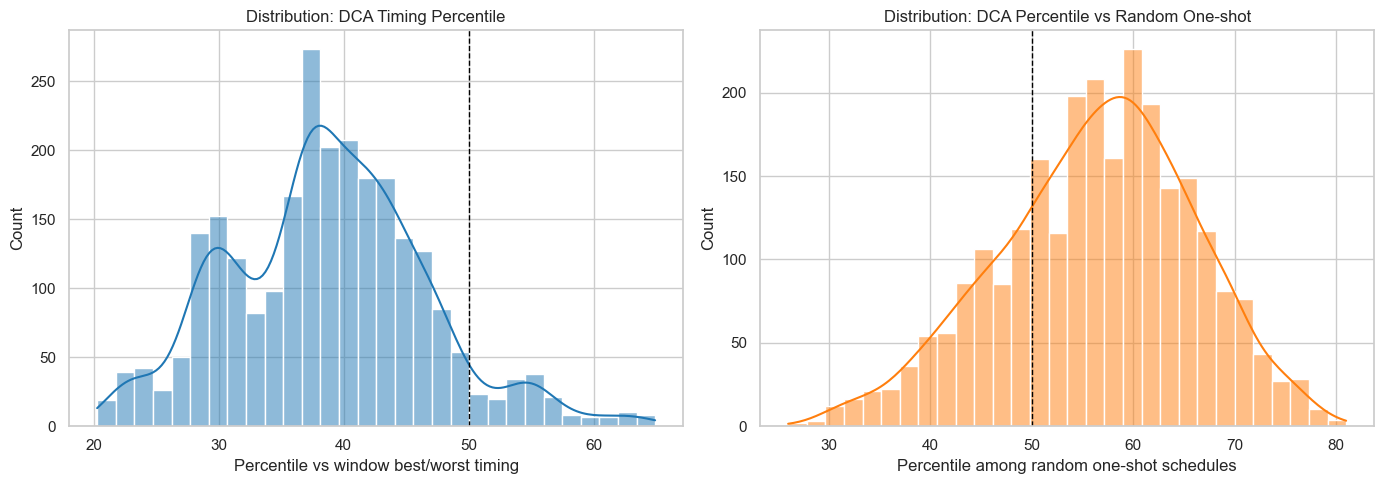

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(dca_eval_df["dca_oracle_percentile"], bins=30, kde=True, ax=axes[0], color="tab:blue")
axes[0].axvline(50, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Distribution: DCA Timing Percentile")
axes[0].set_xlabel("Percentile vs window best/worst timing")

sns.histplot(dca_eval_df["dca_vs_random_lump_percentile"], bins=30, kde=True, ax=axes[1], color="tab:orange")
axes[1].axvline(50, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Distribution: DCA Percentile vs Random One-shot")
axes[1].set_xlabel("Percentile among random one-shot schedules")

plt.tight_layout()
plt.show()

Looking at how dollar cost averaging performs in general, the strategy is in the 57th percentile when compared to investing randomly on a single day. This suggests DCA could be a reasonable baseline approach, as it performs well when compared to random allocations. However, examining the strategy's performance when compared to the best and worst windows, the strategy only performs in the 38th percentile, suggesting this strategy is not especially useful as a timing layer. This is expected, as the purpose of dollar cost averaging is to perform reasonably well in the long-run when the short-term price fluctuations are unknown. The win rate when compared to a lump sum in the beginning of the window is only roughly 35%, which is intuitive for an asset that generally tends to increase in value over time. 

This suggests that DCA as a baseline strategy is a good starting point, but its performance will likely vary across market conditions. To further explore this, we next examine a couple other simple baseline models, such as using 200 day moving averages (MA200) and the relative strength index (RSI). 

## Extended Baseline Strategy Analysis - DCA vs MA200 vs RSI

In [124]:
MA_WINDOW = 200
RSI_WINDOW = 14
MIN_W = 1e-6

STRATEGY_LABELS = {
    "dca_uniform": "DCA (uniform)",
    "ma200_gate": "MA-200 gate",
    "rsi14_tilt": "RSI-14 tilt",
}

strategy_defs = pd.DataFrame(
    {
        "strategy": [
            "DCA (uniform)",
            "MA-200 gate",
            "RSI-14 tilt",
        ],
        "signal_rule": [
            "Equal weight every day.",
            "High weight when prior-day price is below prior-day MA-200; near-zero when above.",
            "Lagged RSI<30 => overweight, 30-70 => neutral, RSI>70 => near-zero.",
        ],
    }
)

strategy_df = btc_daily_pd.copy()
strategy_df["ma200"] = strategy_df["price"].rolling(MA_WINDOW, min_periods=MA_WINDOW // 2).mean()
strategy_df["price_lag"] = strategy_df["price"].shift(1)
strategy_df["ma200_lag"] = strategy_df["ma200"].shift(1)

delta = strategy_df["price"].diff()
gains = delta.clip(lower=0)
losses = (-delta).clip(lower=0)
avg_gain = gains.ewm(alpha=1 / RSI_WINDOW, adjust=False, min_periods=RSI_WINDOW).mean()
avg_loss = losses.ewm(alpha=1 / RSI_WINDOW, adjust=False, min_periods=RSI_WINDOW).mean()
rs = avg_gain / avg_loss.replace(0, np.nan)
strategy_df["rsi14"] = 100 - (100 / (1 + rs))
strategy_df["rsi14_lag"] = strategy_df["rsi14"].shift(1)

with pd.option_context('display.max_colwidth', None):
    display(strategy_defs)

,strategy,signal_rule
0,DCA (uniform),Equal weight every day.
1,MA-200 gate,High weight when prior-day price is below prior-day MA-200; near-zero when above.
2,RSI-14 tilt,"Lagged RSI<30 => overweight, 30-70 => neutral, RSI>70 => near-zero."


In [125]:
def _compute_stable_signal(raw: np.ndarray) -> np.ndarray:
    n = len(raw)
    if n == 0:
        return np.array([])
    if n == 1:
        return np.array([1.0])

    cumsum = np.cumsum(raw)
    running_mean = cumsum / np.arange(1, n + 1)
    with np.errstate(divide="ignore", invalid="ignore"):
        signal = raw / running_mean
    return np.where(np.isfinite(signal), signal, 1.0)


def normalize_weights(raw: np.ndarray, min_w: float = MIN_W) -> np.ndarray:
    """Sequential no-lookahead allocation."""
    raw = np.asarray(raw, dtype=float)
    raw[~np.isfinite(raw)] = 0.0
    raw = np.clip(raw, 0.0, None)

    if raw.sum() <= 0:
        raw = np.ones_like(raw)

    n = len(raw)
    if n == 0:
        return np.array([])

    base = 1.0 / n
    w = np.zeros(n, dtype=float)

    for i in range(n):
        signal_i = _compute_stable_signal(raw[: i + 1])[-1]
        w[i] = signal_i * base

    total = w.sum()
    if total <= 0:
        w = np.full(n, 1.0 / n)
    else:
        if total > 1.0 + 1e-10:
            w *= 1.0 / total

        if n > 1:
            w[-1] = max(1.0 - w[:-1].sum(), 0.0)
        else:
            w[0] = 1.0

    w = np.maximum(w, min_w)
    w = w / w.sum()
    return w


def raw_signal(window_df: pd.DataFrame, strategy_key: str) -> np.ndarray:
    n = len(window_df)

    if strategy_key == "dca_uniform":
        return np.ones(n, dtype=float)

    if strategy_key == "ma200_gate":
        buy_mask = window_df["ma200_lag"].notna() & (window_df["price_lag"] < window_df["ma200_lag"])
        return buy_mask.astype(float).to_numpy()

    if strategy_key == "rsi14_tilt":
        rsi = window_df["rsi14_lag"].to_numpy(dtype=float)
        raw = np.where(rsi < 30, 1.5, np.where(rsi > 70, 0.0, 1.0))
        raw[np.isnan(rsi)] = 1.0
        return raw

    raise ValueError(f"Unknown strategy: {strategy_key}")


def evaluate_strategies_for_window(window_df: pd.DataFrame, rng: np.random.Generator) -> list[dict]:
    inv_price = 1e8 / window_df["price"].to_numpy(dtype=float)
    n_days = len(inv_price)

    random_lump_idx = rng.integers(0, n_days, size=N_RANDOM)
    random_lump_spd = inv_price[random_lump_idx]

    random_multi_idx = rng.integers(0, n_days, size=(N_RANDOM, RANDOM_MULTI_DAYS))
    random_multi_spd = inv_price[random_multi_idx].mean(axis=1)

    oracle_best_spd = inv_price.max()
    oracle_worst_spd = inv_price.min()
    oracle_denom = oracle_best_spd - oracle_worst_spd

    out = []
    for key, label in STRATEGY_LABELS.items():
        w = normalize_weights(raw_signal(window_df, key))
        spd = float((w * inv_price).sum())

        oracle_pct = np.nan if oracle_denom == 0 else 100 * (spd - oracle_worst_spd) / oracle_denom

        out.append(
            {
                "strategy_key": key,
                "strategy": label,
                "spd": spd,
                "oracle_percentile": oracle_pct,
                "pct_vs_random_lump": 100 * (random_lump_spd < spd).mean(),
                "pct_vs_random_multi": 100 * (random_multi_spd < spd).mean(),
                "win_vs_random_lump_median": spd > np.median(random_lump_spd),
                "win_vs_random_multi_median": spd > np.median(random_multi_spd),
                "beats_random_lump_p05": spd > np.quantile(random_lump_spd, 0.05),
            }
        )

    return out

# Evaluate all strategies across rolling 1-year windows.
multi_rng = np.random.default_rng(SEED)
multi_rows = []

for start in window_starts:
    end = start + WINDOW_OFFSET
    window_df = strategy_df.loc[start:end, ["price", "price_lag", "ma200_lag", "rsi14_lag"]].dropna(subset=["price"])

    window_result = evaluate_strategies_for_window(window_df, multi_rng)
    for row in window_result:
        row["window_start"] = start
        row["window_end"] = end
        multi_rows.append(row)

multi_eval_df = pd.DataFrame(multi_rows).sort_values(["strategy", "window_start"])
print(f"Rows in multi-strategy evaluation: {len(multi_eval_df):,}")
multi_eval_df.head(6)

Rows in multi-strategy evaluation: 7,671


,strategy_key,strategy,spd,oracle_percentile,pct_vs_random_lump,pct_vs_random_multi,win_vs_random_lump_median,win_vs_random_multi_median,beats_random_lump_p05,window_start,window_end
0,dca_uniform,DCA (uniform),14767.937008,34.917062,50.0,49.5,True,False,True,2018-01-01,2019-01-01
3,dca_uniform,DCA (uniform),14817.734901,35.111968,51.0,48.5,True,False,True,2018-01-02,2019-01-02
6,dca_uniform,DCA (uniform),14871.414334,35.322066,55.0,57.0,True,True,True,2018-01-03,2019-01-03
9,dca_uniform,DCA (uniform),14924.595888,35.530215,65.0,57.0,True,True,True,2018-01-04,2019-01-04
12,dca_uniform,DCA (uniform),14978.393221,35.740775,56.5,56.0,True,True,True,2018-01-05,2019-01-05
15,dca_uniform,DCA (uniform),15029.848123,35.942166,54.0,54.5,True,True,True,2018-01-06,2019-01-06


In [126]:
strategy_summary_rows = []

for strategy_name, g in multi_eval_df.groupby("strategy"):
    n = len(g)
    win_rate_random_lump = g["win_vs_random_lump_median"].mean()
    p_value = binomtest(int(g["win_vs_random_lump_median"].sum()), n, p=0.5, alternative="greater").pvalue
    downside_rate = g["beats_random_lump_p05"].mean()
    timing_median = g["oracle_percentile"].median()

    primary_pass = (
        (win_rate_random_lump > 0.60)
        and (p_value < 0.01)
        and (downside_rate >= 0.90)
    )

    strategy_summary_rows.append(
        {
            "strategy": strategy_name,
            "windows": n,
            "median_oracle_percentile": timing_median,
            "median_pct_vs_random_lump": g["pct_vs_random_lump"].median(),
            "win_rate_vs_random_lump_median": 100 * win_rate_random_lump,
            "win_rate_vs_random_multi_median": 100 * g["win_vs_random_multi_median"].mean(),
            "downside_rate_vs_random_lump_p05": 100 * downside_rate,
            "sign_test_pvalue_vs_random_lump": p_value,
            "primary_baseline_pass": primary_pass,
            "timing_diagnostic_pass": timing_median >= 50,
        }
    )

strategy_summary = pd.DataFrame(strategy_summary_rows).sort_values(
    ["primary_baseline_pass", "median_oracle_percentile"],
    ascending=[False, False],
)

strategy_summary

,strategy,windows,median_oracle_percentile,median_pct_vs_random_lump,win_rate_vs_random_lump_median,win_rate_vs_random_multi_median,downside_rate_vs_random_lump_p05,sign_test_pvalue_vs_random_lump,primary_baseline_pass,timing_diagnostic_pass
1,MA-200 gate,2557,38.895523,63.5,77.864685,54.986312,100.0,5.159084e-185,True,False
0,DCA (uniform),2557,38.493668,57.0,75.205319,61.087212,100.0,4.488439e-150,True,False
2,RSI-14 tilt,2557,38.196954,56.5,72.976144,42.940946,100.0,4.822664e-124,True,False


In [127]:
# Direct comparison vs DCA
pivot_spd = multi_eval_df.pivot(index="window_start", columns="strategy", values="spd")
pivot_oracle = multi_eval_df.pivot(index="window_start", columns="strategy", values="oracle_percentile")

dca_label = STRATEGY_LABELS["dca_uniform"]

comparison_rows = []
for strategy_name in strategy_summary["strategy"]:
    if strategy_name == dca_label:
        continue

    common_idx = pivot_spd[[dca_label, strategy_name]].dropna().index
    if len(common_idx) == 0:
        continue

    spd_delta = pivot_spd.loc[common_idx, strategy_name] - pivot_spd.loc[common_idx, dca_label]
    oracle_delta = pivot_oracle.loc[common_idx, strategy_name] - pivot_oracle.loc[common_idx, dca_label]

    win_vs_dca = (spd_delta > 0).mean()
    p_value_vs_dca = binomtest(int((spd_delta > 0).sum()), len(spd_delta), p=0.5, alternative="greater").pvalue

    comparison_rows.append(
        {
            "strategy": strategy_name,
            "windows": len(common_idx),
            "median_spd_delta_vs_dca": spd_delta.median(),
            "median_oracle_delta_vs_dca": oracle_delta.median(),
            "win_rate_vs_dca": 100 * win_vs_dca,
            "sign_test_pvalue_vs_dca": p_value_vs_dca,
        }
    )

vs_dca_table = pd.DataFrame(comparison_rows).sort_values("median_spd_delta_vs_dca", ascending=False)
vs_dca_table

,strategy,windows,median_spd_delta_vs_dca,median_oracle_delta_vs_dca,win_rate_vs_dca,sign_test_pvalue_vs_dca
0,MA-200 gate,2557,20.263415,0.441468,52.170512,0.014792
1,RSI-14 tilt,2557,-10.303685,-0.412259,39.538522,1.000000


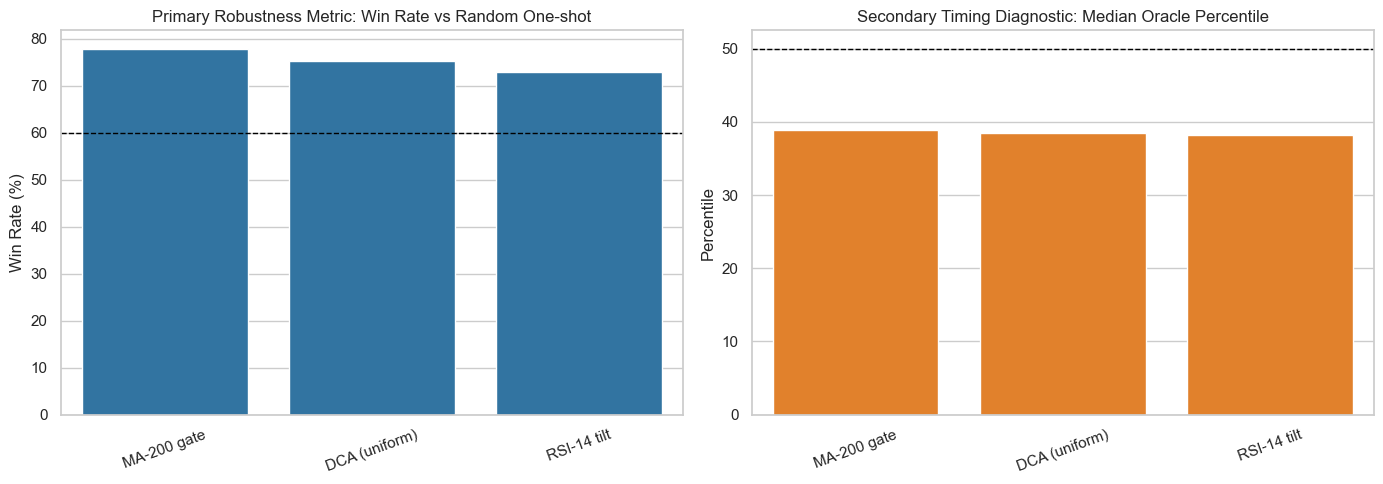

In [128]:
# Visual summary: robustness pass/fail and timing median by strategy.
plot_df = strategy_summary.copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    data=plot_df,
    x="strategy",
    y="win_rate_vs_random_lump_median",
    ax=axes[0],
    color="tab:blue",
)
axes[0].axhline(60, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Primary Robustness Metric: Win Rate vs Random One-shot")
axes[0].set_ylabel("Win Rate (%)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=20)

sns.barplot(
    data=plot_df,
    x="strategy",
    y="median_oracle_percentile",
    ax=axes[1],
    color="tab:orange",
)
axes[1].axhline(50, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Secondary Timing Diagnostic: Median Oracle Percentile")
axes[1].set_ylabel("Percentile")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

## Regime Analysis

In [129]:
# Basic Regime Analysis DCA
dca_eval_regime = dca_eval_df.copy()

trend_bins = pd.cut(
    dca_eval_regime["trend_1y"],
    bins=[-np.inf, -0.20, 0.20, np.inf],
    labels=["bear", "sideways", "bull"],
)

vol_median = dca_eval_regime["ann_vol_1y"].median()
vol_bucket = np.where(dca_eval_regime["ann_vol_1y"] > vol_median, "high_vol", "low_vol")

dca_eval_regime["trend_regime"] = trend_bins.astype(str)
dca_eval_regime["vol_regime"] = vol_bucket

regime_summary = (
    dca_eval_regime
    .groupby(["trend_regime", "vol_regime"], dropna=False)
    .agg(
        windows=("dca_spd", "count"),
        median_oracle_pct=("dca_oracle_percentile", "median"),
        win_vs_lump_start=("win_vs_lump_start", "mean"),
        win_vs_lump_end=("win_vs_lump_end", "mean"),
        win_vs_random_lump=("win_vs_random_lump_median", "mean"),
        beats_random_lump_p05=("beats_random_lump_p05", "mean"),
    )
    .reset_index()
)

for col in ["win_vs_lump_start", "win_vs_lump_end", "win_vs_random_lump", "beats_random_lump_p05"]:
    regime_summary[col] = 100 * regime_summary[col]

regime_summary

,trend_regime,vol_regime,windows,median_oracle_pct,win_vs_lump_start,win_vs_lump_end,win_vs_random_lump,beats_random_lump_p05
0,bear,high_vol,254,36.125800,78.740157,5.118110,86.614173,100.0
1,bear,low_vol,293,45.046889,100.000000,31.399317,54.266212,100.0
2,bull,high_vol,813,37.084609,20.787208,93.603936,79.581796,100.0
3,bull,low_vol,860,39.476043,3.139535,100.000000,70.697674,100.0
4,sideways,high_vol,211,31.906538,69.194313,68.246445,95.260664,100.0
5,sideways,low_vol,126,40.038459,50.793651,61.111111,69.841270,100.0


In [130]:
# Regime-aware baseline comparison
regime_labels = (
    dca_eval_regime
    .reset_index()[["window_start", "trend_regime", "vol_regime"]]
)

multi_eval_regime_df = multi_eval_df.merge(regime_labels, on="window_start", how="left")

strategy_regime_summary = (
    multi_eval_regime_df
    .groupby(["strategy", "trend_regime", "vol_regime"], dropna=False)
    .agg(
        windows=("spd", "count"),
        median_spd=("spd", "median"),
        median_oracle_percentile=("oracle_percentile", "median"),
        win_rate_vs_random_lump_median=("win_vs_random_lump_median", "mean"),
        downside_rate_vs_random_lump_p05=("beats_random_lump_p05", "mean"),
    )
    .reset_index()
)

strategy_regime_summary["win_rate_vs_random_lump_median"] *= 100
strategy_regime_summary["downside_rate_vs_random_lump_p05"] *= 100

strategy_regime_summary.sort_values(["trend_regime", "vol_regime", "median_spd"], ascending=[True, True, False])

,strategy,trend_regime,vol_regime,windows,median_spd,median_oracle_percentile,win_rate_vs_random_lump_median,downside_rate_vs_random_lump_p05
6,MA-200 gate,bear,high_vol,254,2815.474636,35.760336,93.700787,100.0
12,RSI-14 tilt,bear,high_vol,254,2643.695159,36.970220,88.188976,100.0
0,DCA (uniform),bear,high_vol,254,2619.852978,36.125800,86.614173,100.0
1,DCA (uniform),bear,low_vol,293,4272.249161,45.046889,54.266212,100.0
7,MA-200 gate,bear,low_vol,293,4267.073302,42.487791,43.686007,100.0
13,RSI-14 tilt,bear,low_vol,293,4256.505922,45.732103,52.901024,100.0
2,DCA (uniform),bull,high_vol,813,10902.157434,37.084609,79.581796,100.0
14,RSI-14 tilt,bull,high_vol,813,10749.954116,34.871519,75.399754,100.0
8,MA-200 gate,bull,high_vol,813,8999.383944,29.791675,66.174662,100.0
3,DCA (uniform),bull,low_vol,860,2216.660853,39.476043,70.697674,100.0


In [131]:
# Does the best baseline vary by regime?
best_strategy_by_regime = (
    strategy_regime_summary
    .sort_values("median_spd", ascending=False)
    .groupby(["trend_regime", "vol_regime"], as_index=False)
    .head(1)
    .sort_values(["trend_regime", "vol_regime"])
)

best_counts = (
    best_strategy_by_regime
    .groupby("strategy")
    .size()
    .rename("regimes_where_best")
    .reset_index()
    .sort_values("regimes_where_best", ascending=False)
)

strategy_dispersion = (
    strategy_regime_summary
    .groupby("strategy")
    .agg(
        median_spd_min=("median_spd", "min"),
        median_spd_max=("median_spd", "max"),
        median_oracle_min=("median_oracle_percentile", "min"),
        median_oracle_max=("median_oracle_percentile", "max"),
        win_rate_min=("win_rate_vs_random_lump_median", "min"),
        win_rate_max=("win_rate_vs_random_lump_median", "max"),
    )
    .reset_index()
)
strategy_dispersion["median_spd_range"] = strategy_dispersion["median_spd_max"] - strategy_dispersion["median_spd_min"]
strategy_dispersion["median_oracle_range"] = strategy_dispersion["median_oracle_max"] - strategy_dispersion["median_oracle_min"]
strategy_dispersion["win_rate_range"] = strategy_dispersion["win_rate_max"] - strategy_dispersion["win_rate_min"]

print("Best strategy by regime:")
best_strategy_view = best_strategy_by_regime[["trend_regime", "vol_regime", "strategy", "windows", "median_spd", "median_oracle_percentile", "win_rate_vs_random_lump_median"]]
print(best_strategy_view.to_string(index=False))

print("\nBest-count summary:")
print(best_counts.to_string(index=False))

print("\nCross-regime dispersion by strategy:")
strategy_dispersion_view = strategy_dispersion[["strategy", "median_spd_range", "median_oracle_range", "win_rate_range"]].sort_values("win_rate_range", ascending=False)
print(strategy_dispersion_view.to_string(index=False))

Best strategy by regime:
trend_regime vol_regime      strategy  windows   median_spd  median_oracle_percentile  win_rate_vs_random_lump_median
        bear   high_vol   MA-200 gate      254  2815.474636                 35.760336                       93.700787
        bear    low_vol DCA (uniform)      293  4272.249161                 45.046889                       54.266212
        bull   high_vol DCA (uniform)      813 10902.157434                 37.084609                       79.581796
        bull    low_vol DCA (uniform)      860  2216.660853                 39.476043                       70.697674
    sideways   high_vol   MA-200 gate      211 12434.565448                 37.772943                       98.578199
    sideways    low_vol   MA-200 gate      126  1680.138589                 65.047026                       73.015873

Best-count summary:
     strategy  regimes_where_best
DCA (uniform)                   3
  MA-200 gate                   3

Cross-regime dispersion b

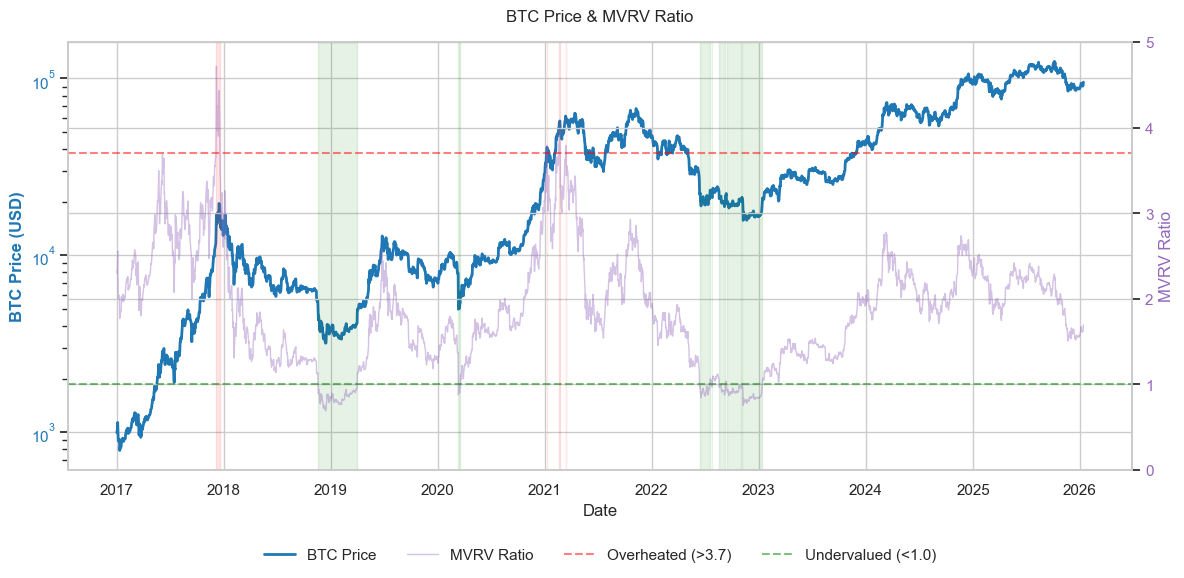

In [132]:
btc_price_pd = (
    btc_df
    .select(["time", "PriceUSD_coinmetrics"])
    .drop_nulls()
    .to_pandas()
)
onchain_df = btc_df.select(["time", "PriceUSD_coinmetrics", "HashRate", "CapMVRVCur"]).drop_nulls().to_pandas()
onchain_df["time"] = pd.to_datetime(onchain_df["time"])

# Filter to post-2017
onchain_df = onchain_df[onchain_df["time"] >= "2017-01-01"]

start_date = onchain_df["time"].min()
plot_price_pd = btc_price_pd[btc_price_pd["time"] >= start_date]

fig, ax1 = plt.subplots(figsize=(12, 6))

color_price = "tab:blue"
ax1.set_xlabel("Date")
ax1.set_ylabel("BTC Price (USD)", color=color_price, fontweight="bold")

ax1.plot(plot_price_pd["time"], plot_price_pd["PriceUSD_coinmetrics"], color=color_price, linewidth=2.0, label="BTC Price")
ax1.tick_params(axis="y", labelcolor=color_price)
ax1.set_yscale("log")

ax2 = ax1.twinx()
color_mvrv = "tab:purple"
ax2.set_ylabel("MVRV Ratio", color=color_mvrv)

ax2.plot(onchain_df["time"], onchain_df["CapMVRVCur"], color=color_mvrv, linewidth=1.0, alpha=0.4, label="MVRV Ratio")

ax2.axhline(3.7, color="red", linestyle="--", alpha=0.5, label="Overheated (>3.7)")
ax2.axhline(1.0, color="green", linestyle="--", alpha=0.5, label="Undervalued (<1.0)")

ax2.fill_between(onchain_df["time"], 0, 5, where=(onchain_df["CapMVRVCur"] > 3.7), color="red", alpha=0.1)
ax2.fill_between(onchain_df["time"], 0, 5, where=(onchain_df["CapMVRVCur"] < 1), color="green", alpha=0.1)

ax2.set_ylim(0,5)
ax2.tick_params(axis="y", labelcolor=color_mvrv)

plt.title("BTC Price & MVRV Ratio", pad=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

fig.tight_layout()
plt.show()

The plot above shows the price of bitcoin overlaid on a plot of the MVRV ratio. Using MVRV ratio values of less than 1.0 to indicate undervalued regions (shown in green) and values greater than 3.7 to indicate overvalued regions (shown in red), this analysis suggests that MVRV can be a useful leading indicator to help identify bull and bear market conditions. 

## Polymarket

In [133]:
btc_targets = (
    poly_data['markets']
    .with_columns([
        pl.col("question").str.to_lowercase().alias("question_lc"),
    ])
    .filter(
        (pl.col("question_lc").str.contains("bitcoin|btc")) & 
        (pl.col("question_lc").str.contains("hit|reach|above|below|reach")) &
        (pl.col("volume") > 1000000)
    )
    .with_columns([
        pl.when(pl.col("question_lc").str.contains("above|reach|hit")).then(pl.lit(1))
        .when(pl.col("question_lc").str.contains("below|under")).then(pl.lit(-1))
        .otherwise(pl.lit(0)).alias("orientation")
    ])
    .filter(pl.col("orientation") != 0)
)

print(f"High-Liquidity BTC Markets: {btc_targets.height}")
with pl.Config(fmt_str_lengths=150):
    display(
        btc_targets.select(["market_id", "question", "volume"])
        .sort("volume", descending=True)
        .head(5)
    )

High-Liquidity BTC Markets: 174


market_id,question,volume
str,str,f64
"""512600""","""Will Bitcoin hit $100k in November?""",2.8587e7
"""255229""","""Will Bitcoin hit $100k in 2024?""",2.2807e7
"""618949""","""Will Bitcoin reach $200k in October?""",1.5617e7
"""659233""","""Will Bitcoin reach $200,000 in November?""",1.3589e7
"""516864""","""Will Bitcoin reach $150,000 by December 31, 2025?""",1.2479e7


In [134]:
target_ids = btc_targets["market_id"].to_list()

daily_probs = (
    poly_data["trades"]
    .filter(pl.col("market_id").is_in(target_ids))
    .with_columns(pl.col("timestamp").dt.date().alias("date"))
    .group_by("date", "market_id")
    .agg(pl.col("price").mean().alias("avg_prob"))
    .join(btc_targets.select(["market_id", "orientation"]), on="market_id")
    .with_columns(
        pl.when(pl.col("orientation") == 1).then(pl.col("avg_prob"))
        .otherwise(1 - pl.col("avg_prob")).alias("bullish_prob")
    )
    .sort(["market_id", "date"])
    .with_columns(
        pl.col("bullish_prob").diff().over("market_id").alias("prob_delta")
    )
)

daily_sentiment = (
    daily_probs
    .group_by("date")
    .agg(pl.col("prob_delta").mean().alias("net_sentiment_delta"))
    .sort("date")
    .drop_nulls()
)

non_zero_deltas = daily_sentiment.filter(pl.col("net_sentiment_delta").abs() > 1e-9)
print(f"Days with active sentiment shift: {non_zero_deltas.height} / {daily_sentiment.height}")
print("Sample deltas:")
print(non_zero_deltas.head())

Days with active sentiment shift: 244 / 245
Sample deltas:
shape: (5, 2)
┌────────────┬─────────────────────┐
│ date       ┆ net_sentiment_delta │
│ ---        ┆ ---                 │
│ date       ┆ f64                 │
╞════════════╪═════════════════════╡
│ 2025-04-08 ┆ -0.023032           │
│ 2025-04-09 ┆ -0.041688           │
│ 2025-04-10 ┆ 0.019004            │
│ 2025-04-11 ┆ -0.006747           │
│ 2025-04-12 ┆ -0.018916           │
└────────────┴─────────────────────┘


In [135]:
horizons = [7, 14, 30, 60]
btc_cols = [pl.col("time").dt.date().alias("date"), pl.col("PriceUSD_coinmetrics")]

btc_returns = btc_df.select(btc_cols)
for h in horizons:
    btc_returns = btc_returns.with_columns(
        (pl.col("PriceUSD_coinmetrics").shift(-h) / pl.col("PriceUSD_coinmetrics") - 1).alias(f"fwd_{h}d_ret")
    )

daily_activity = (
    poly_data["trades"]
    .filter(pl.col("market_id").is_in(btc_targets["market_id"].to_list()))
    .with_columns(pl.col("timestamp").dt.date().alias("date"))
    .group_by("date")
    .agg(pl.len().alias("daily_trade_count"))
    .with_columns(
        ((pl.col("daily_trade_count") - pl.col("daily_trade_count").mean()) / pl.col("daily_trade_count").std()).alias("activity_zscore")
    )
)

analysis_df = (
    daily_sentiment
    .join(daily_activity, on="date", how="left")
    .join(btc_returns, on="date")
    .drop_nulls(subset=[f"fwd_{h}d_ret" for h in horizons])
)

print(f"Analysis sample size: {analysis_df.height} days")

Analysis sample size: 216 days


In [136]:
# T-Tests and Monte Carlo Simulation
sentiment_threshold = analysis_df["net_sentiment_delta"].quantile(0.95)
activity_threshold = 1.5 # z-score

def run_permutation_test(df, mask_col, ret_col, n_iter=1000):
    observed_diff = df.filter(pl.col(mask_col))[ret_col].mean() - df.filter(~pl.col(mask_col))[ret_col].mean()

    null_diffs = []
    vals = df[ret_col].to_numpy()
    n_shocks = df.filter(pl.col(mask_col)).height

    for _ in range(n_iter):
        perm = np.random.permutation(vals)
        null_diff = perm[:n_shocks].mean() - perm[n_shocks:].mean()
        null_diffs.append(null_diff)

    p_sim = (np.abs(null_diffs) >= np.abs(observed_diff)).mean()
    return observed_diff, p_sim

analysis_df = analysis_df.with_columns([
    (pl.col("net_sentiment_delta") >= sentiment_threshold).alias("is_sent_shock"),
    (pl.col("activity_zscore") >= activity_threshold).alias("is_act_shock")
])

results = []
for h in horizons:
    ret_col = f"fwd_{h}d_ret"

    #Sentiment Stats
    sent_diff, sent_p_sim = run_permutation_test(analysis_df, "is_sent_shock", ret_col)

    #Activitiy Stats
    act_diff, act_p_sim = run_permutation_test(analysis_df, "is_act_shock", ret_col)

    results.append({
        "horizon": f"{h}d",
        "sentiment_shock_diff": sent_diff,
        "sentiment_p_monte_carlo": sent_p_sim,
        "activity_shock_diff": act_diff,
        "activity_p_monte_carlo": act_p_sim
    })

report = pl.DataFrame(results)
print("Abnormal Returns & Sim-based P-values:")
print(report)


Abnormal Returns & Sim-based P-values:
shape: (4, 5)
┌─────────┬──────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ horizon ┆ sentiment_shock_diff ┆ sentiment_p_monte_c ┆ activity_shock_diff ┆ activity_p_monte_ca │
│ ---     ┆ ---                  ┆ arlo                ┆ ---                 ┆ rlo                 │
│ str     ┆ f64                  ┆ ---                 ┆ f64                 ┆ ---                 │
│         ┆                      ┆ f64                 ┆                     ┆ f64                 │
╞═════════╪══════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 7d      ┆ -0.014762            ┆ 0.338               ┆ -0.002668           ┆ 0.815               │
│ 14d     ┆ -0.02991             ┆ 0.156               ┆ 0.018122            ┆ 0.264               │
│ 30d     ┆ -0.046207            ┆ 0.137               ┆ 0.053746            ┆ 0.027               │
│ 60d     ┆ -0.079613            ┆ 0.0

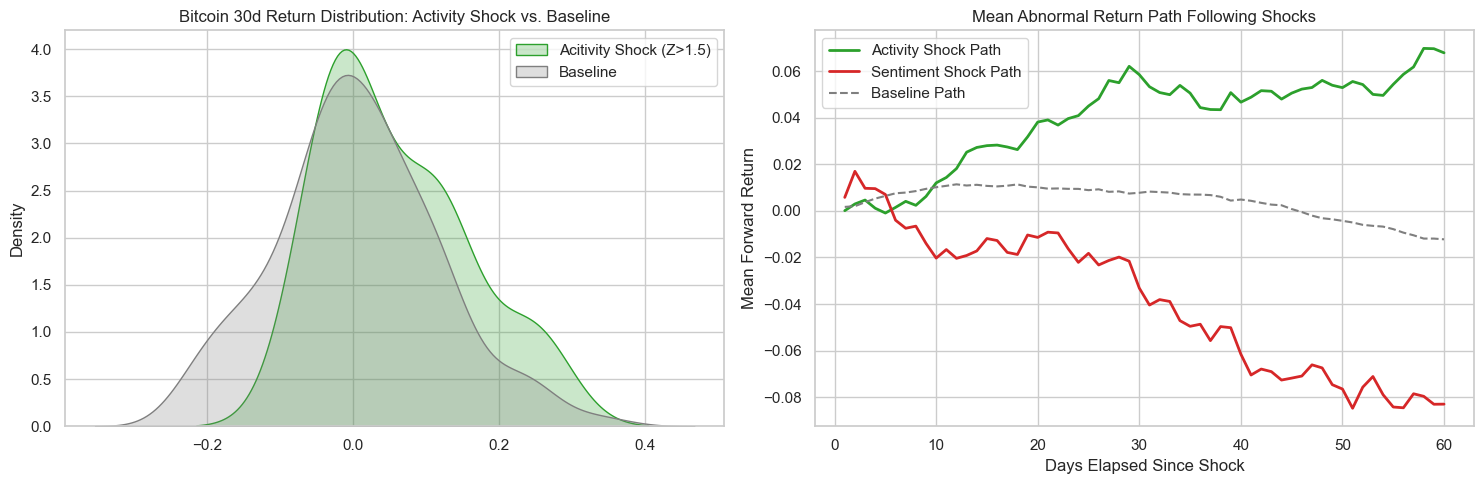

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Activity Shock Distribution (30d)
sns.kdeplot(analysis_df.filter(pl.col("is_act_shock"))["fwd_30d_ret"].to_numpy(),
            label="Acitivity Shock (Z>1.5)", fill=True, ax=axes[0], color="tab:green")
sns.kdeplot(analysis_df.filter(~pl.col("is_act_shock"))["fwd_30d_ret"].to_numpy(),
            label="Baseline", fill=True, ax=axes[0], color="tab:grey")
axes[0].set_title("Bitcoin 30d Return Distribution: Activity Shock vs. Baseline")
axes[0].legend()

# Cumulative Return Paths
path_horizons = list(range(1,61))
path_btc = btc_df.select([pl.col("time").dt.date().alias("date"), "PriceUSD_coinmetrics"])
for h in path_horizons:
    path_btc = path_btc.with_columns(
        (pl.col("PriceUSD_coinmetrics").shift(-h) / pl.col("PriceUSD_coinmetrics") - 1).alias(f"ret_{h}")
    )

path_df = analysis_df.select(["date", "is_act_shock", "is_sent_shock"]).join(path_btc, on="date")

act_path = [path_df.filter(pl.col("is_act_shock"))[f"ret_{h}"].mean() for h in path_horizons]
sent_path = [path_df.filter(pl.col("is_sent_shock"))[f"ret_{h}"].mean() for h in path_horizons]
base_path = [path_df.filter(~pl.col("is_act_shock") & ~pl.col("is_sent_shock"))[f"ret_{h}"].mean() for h in path_horizons]

axes[1].plot(path_horizons, act_path, label="Activity Shock Path", color="tab:green", linewidth=2)
axes[1].plot(path_horizons, sent_path, label="Sentiment Shock Path", color="tab:red", linewidth=2)
axes[1].plot(path_horizons, base_path, label="Baseline Path", color="tab:grey", linestyle='--')
axes[1].set_title("Mean Abnormal Return Path Following Shocks")
axes[1].set_xlabel("Days Elapsed Since Shock")
axes[1].set_ylabel("Mean Forward Return")
axes[1].legend()

plt.tight_layout()
plt.show()